In [15]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stix'

In [16]:
device = torch.device("cpu")

### Defining netwroks with two linear layers. The network reads 3 parameters D_in, H, D_out, where H is the hidden dimension. The linear network works as two matrix multiplication. The first linear layer clamps output at 0 as RELU. The second linear layer output logits.

In [17]:
class TwoLayerNet(nn.Module):
    
    def __init__(self, D_in, H, D_out):    
        super(TwoLayerNet, self).__init__()
        
        self.linear1=nn.Linear(D_in, H)
        self.linear2=nn.Linear(H, D_out)
    
    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        
        return y_pred

### Predefined parameters

In [24]:
# Average energy
E_mean=3
# N=number of sample, D_in=Input dimensions, H=Hidden dimension, D_out=Number of classes
N, D_in, H, D_out = 64, 200, 100, 32 
# Learning rate
lr=1e-4
# Number of optimization
num_ops=3000 # try 10000!

### Predefined data

In [19]:
label='fix'

In [20]:
# Input data
X = torch.randn(N, D_in)
# Lagrange multiplier
l = torch.tensor(1, requires_grad=True, dtype=torch.float32)

if label is 'fix':
    shift=5
    y=torch.ones(N, dtype=torch.long)+shift
elif label is 'random':
    y=torch.empty(N, dtype=torch.long).random_(D_out)
else:
    print('No target label.')
    
# Artifical energy levels
E=np.array([[i+1 for i in range(D_out)] for j in range(N)])
E=torch.tensor(E, dtype=torch.float32)

### Predefined functions

In [21]:
softmax=torch.nn.Softmax(dim=-1)

### Building model

In [27]:
model = TwoLayerNet(D_in, H, D_out)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

### Training

In [ ]:
for i in range(num_ops):
    Y=model(X)
    loss = loss_fn(Y, y)+l*(E_mean-torch.mean(E*softmax(Y)))
#     loss = l*(E_mean-torch.mean(E*softmax(Y)))
    
    if i % 1000 == 999:
        print(i, loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    l.data.add_(-lr*l.grad.data)
    l.grad.zero_()
    
print('(E,l)={} {:.3}'.format(E_mean, l.data))

### Checking performance of model

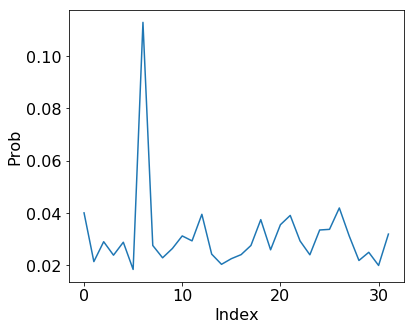

In [10]:
test_X = torch.randn(N, D_in)
test_Y=model(test_X)

plt.rcParams['figure.figsize']=(6,5)
plt.plot(softmax(test_Y).detach().numpy()[0])
plt.tick_params(axis='both', which='both', labelsize=16)
plt.xlabel('Index', size=16)
plt.ylabel('Prob', size=16)
plt.show()

## Training with different observed average energy

### Predefined parameters

In [11]:
E_mean_list=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4]

### Predefined functions

In [12]:
def compute_l(X, l, D_in, H, D_out, num_ops):
    """
    Compute Langrange multiplier l.
    """

    for i in range(num_ops):
        Y=model(X)
        loss = loss_fn(Y, y)+l*(E_mean-torch.mean(E*softmax(Y)))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        l.data.add_(-lr*l.grad.data)
        l.grad.zero_()
    
    return l.data.item()


### Trainings

In [13]:
ls=[]
for E_mean in E_mean_list:
    
    X = torch.randn(N, D_in)
    l = torch.tensor(1, requires_grad=True, dtype=torch.float32)
    l_final = compute_l(X, l, D_in, H, D_out, num_ops)
    print(l_final)
    ls.append(l_final)
    

1.1294220685958862
1.045278787612915
0.9720120429992676
0.9051822423934937
0.8409008979797363
0.7782265543937683
0.7169197201728821
0.655023992061615
0.5937061309814453
0.5321058630943298
0.47108590602874756
0.4106146991252899
0.34988492727279663


### Checking the behavior.

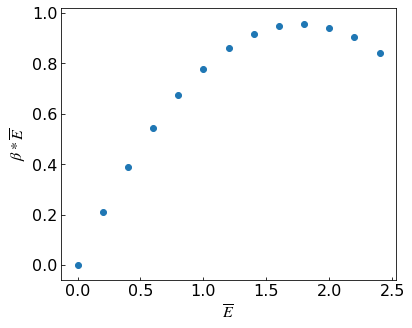

In [14]:
E_mean_list=np.array(E_mean_list)
ls=np.array(ls)

fig, ax=plt.subplots(figsize=(6,5))
ax.scatter(E_mean_list, ls*E_mean_list)
ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.set_xlabel('$\overline{E}$', size=16)
ax.set_ylabel('$\\beta*\overline{E}$', size=16)

plt.show()